# Eminem Song Lyrics Generation with GPT-2

This Jupyter notebook documents the process of developing a GPT-2 based model for generating song lyrics stylistically similar to those of Eminem. The intention is to explore the application of the GPT-2 transformer model.

## Project Overview

- **Objective**:
- **Data Source**:
- **Approach**:
- **Expected Outcome**:

Upon completion of this notebook, the resultant model will be evaluated for its efficacy in generating lyrics similar to Eminem's, and the findings from this exercise will be documented.


In [11]:
######imports

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
import numpy as np
import pandas as pd
import os
import re
from utilities import import_data_from_location, handle_special_characters
import utilities as util

# Initialize the tokenizer and model from the pre-trained 'gpt2' model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Check for GPU availability and set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

print(f"Setup completed. Using device: {device}")

special_tokens = {'pad_token': '<PAD>'}
special_tokens_dict = {'additional_special_tokens': ['<startsong>', '<endsong>']}

tokenizer.add_special_tokens(special_tokens)
tokenizer.add_special_tokens(special_tokens_dict)

model.resize_token_embeddings(len(tokenizer))





Setup completed. Using device: cuda


Embedding(50260, 768)

## Data Preprocessing

In this section, we'll prepare the Eminem song lyrics dataset for training the GPT-2 model. This involves loading the dataset, cleaning the text, tokenizing the lyrics, and organizing the data into a suitable format for the model.



In [12]:

file_loc = './Eminem_Lyrics.csv'
songs = util.import_data_from_location(file_loc)

def remove_sections(text):
    # Define a regular expression pattern to match the song sections and their variations
    pattern = r"\[(Verse|Intro|Chorus|Interlude|Outro).*?\]"

    # Replace the matched patterns with an empty string
    cleaned_text = re.sub(pattern, "", text)

    return cleaned_text.strip()


def PreProcess(df,col):
    df[col] = df[col].apply(remove_sections)
    print(f"Lyrics after remove_sections: {df[col][0]}")
    df[col] = df[col].apply(util.handle_special_characters)
    print(f"Lyrics after handle_special_characters: {df[col][0]}")
    df[col] = df[col].apply(util.remove_non_ascii_characters)
    print(f"Lyrics after remove_non_ascii_characters: {df[col][0]}")
    df[col] = df[col].apply(util.expand_contractions, args=(util.contractions_dict,))
    print(f"Lyrics after expanding contractions: {df[col][0]}")
    return df

preprocessed_songs = PreProcess(songs, 'Lyrics')


Error with encoding utf-8: 'utf-8' codec can't decode byte 0x92 in position 6: invalid start byte
Success with encoding: latin1
Lyrics after remove_sections: Thus far, this album has provided musical accompaniment to make your passing pleasant
Our next number is designed to drown out the sound of shovels
Music to be buried by
Lyrics after handle_special_characters: Thus far, this album has provided musical accompaniment to make your passing pleasant Our next number is designed to drown out the sound of shovels Music to be buried by
Removed non-ASCII characters: 
Removed non-ASCII characters: á
Removed non-ASCII characters: 
Removed non-ASCII characters: 
Removed non-ASCII characters: ó
Removed non-ASCII characters: 
Removed non-ASCII characters: 
Removed non-ASCII characters: é
Removed non-ASCII characters: 
Removed non-ASCII characters: 
Removed non-ASCII characters: 
Removed non-ASCII characters: ö
Removed non-ASCII characters: 
Removed non-ASCII characters: 
Removed no

In [13]:
#Define the custom dataset class for song lyrics
class SongDataset(Dataset):
    """A custom Dataset class for song lyrics."""
    def __init__(self, txt_list, tokenizer, max_length):
        """Initializes the dataset with tokenized and encoded song lyrics."""
        self.input_ids = []
        self.attn_masks = []

        # Tokenize and encode each song in the dataset
        for txt in txt_list:
            encodings = tokenizer('<startsong> ' + txt + ' <endsong>', truncation=True, max_length=max_length, padding="max_length")
            self.input_ids.append(torch.tensor(encodings['input_ids']))
            self.attn_masks.append(torch.tensor(encodings['attention_mask']))

    def __len__(self):
        """Returns the number of songs in the dataset."""
        return len(self.input_ids)

    def __getitem__(self, idx):
        """Returns the tokenized and encoded data of the song at the specified index."""
        return self.input_ids[idx], self.attn_masks[idx]



# Assuming `preprocessed_songs` is a list of preprocessed song lyrics
dataset = SongDataset(preprocessed_songs['Lyrics'], tokenizer, max_length=512)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

## Training Loop

In [14]:
epochs = 10
optimizer = AdamW(model.parameters(), lr=1e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dataloader) * epochs)

epoch_losses = []
epoch_perplexities = []
# Training loop with gradient accumulation
gradient_accumulation_steps = 4  # Adjust as needed for memory management
model.train()

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    total_loss = 0
    optimizer.zero_grad()  # Initialize gradients to zero at the start of each epoch

    for batch_idx, (input_ids, masks) in enumerate(dataloader):
        input_ids, masks = input_ids.to(device), masks.to(device)
        outputs = model(input_ids, labels=input_ids, attention_mask=masks)
        loss = outputs.loss / gradient_accumulation_steps  # Adjust loss for gradient accumulation
        loss.backward()  # Accumulate gradients
        total_loss += loss.item()

        # Step the optimizer and scheduler every `gradient_accumulation_steps`
        if (batch_idx + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()  # Clear gradients after updating weights

        # Periodically print the loss, perplexity, and a sample prediction
        if batch_idx % 10 == 0:
            adjusted_loss = loss.item() * gradient_accumulation_steps  # Adjust the loss back for reporting
            perplexity = np.exp(adjusted_loss)
            print(f"Batch {batch_idx}/{len(dataloader)} - Loss: {adjusted_loss:.4f} - Perplexity: {perplexity:.2f}")

            # Decode and display a sample input, target, and prediction for qualitative evaluation
            input_sequence = tokenizer.decode(input_ids[0], skip_special_tokens=True)
            prediction_ids = torch.argmax(outputs.logits, dim=-1)[0]
            prediction_sequence = tokenizer.decode(prediction_ids, skip_special_tokens=True)

            print(f"  Input Sequence: {input_sequence}")
            print(f"  Target Sequence: {input_sequence}")  # Target is the same as input in language modeling
            print(f"  Prediction: {prediction_sequence}\n")

    # Compute and report the average loss and perplexity for the epoch
    avg_loss = total_loss / len(dataloader)
    avg_perplexity = np.exp(avg_loss)
    epoch_losses.append(avg_loss)
    epoch_perplexities.append(avg_perplexity)
    print(f"End of Epoch {epoch+1} - Average Loss: {avg_loss:.4f} - Average Perplexity: {avg_perplexity:.2f}\n")


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10
Batch 0/87 - Loss: 60.6444 - Perplexity: 217527436230210814627282944.00
  Input Sequence:  This is from me to you, not you to me This is from me to you, not you to me This is from me to you, not you to me This is from me to you 
  Target Sequence:  This is from me to you, not you to me This is from me to you, not you to me This is from me to you, not you to me This is from me to you 
  Prediction: 

Batch 10/87 - Loss: 77.8172 - Perplexity: 6245928335927716024179208807776256.00
  Input Sequence:  Meet Eddie, 23 years old Fed up with life and the way things are going Damn, i am going fucking insane He decides to rob a liquor store I gotta take this shit, I cannot take it no more, holmes But on his way in, he has a sudden change of heart Shit is mine And suddenly I gotta do this His conscience comes into play I gotta do this Alright, stop Huh Now before you walk in the door of this liquor store And try to get money out the drawer You better think of the consequence Who are you

## Training loss and perplexity

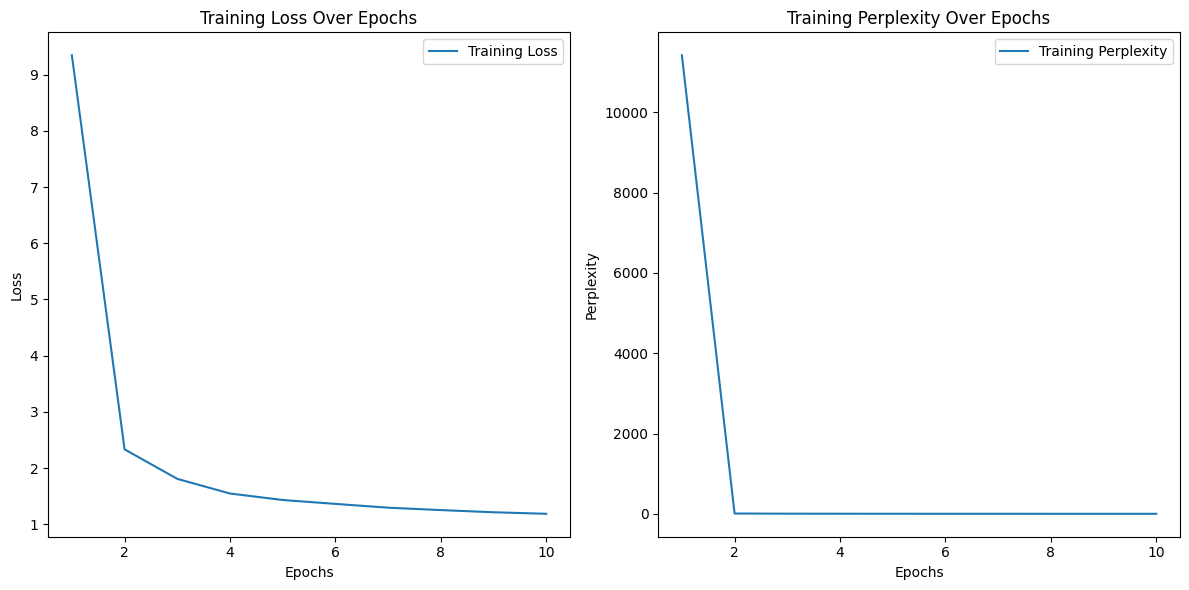

In [17]:
import matplotlib.pyplot as plt

def plot_metrics(epoch_losses, epoch_perplexities):
    epochs_range = range(1, len(epoch_losses) + 1)
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, epoch_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, epoch_perplexities, label='Training Perplexity')
    plt.xlabel('Epochs')
    plt.ylabel('Perplexity')
    plt.title('Training Perplexity Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(epoch_losses, epoch_perplexities)

## Generation of new songs

In [24]:
model.eval()
prompt = "<startsong>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

def generate_text_samples(model, tokenizer, prompt, device, num_samples=3):
    """
    Generates text samples with different configurations using the specified model and tokenizer.

    Parameters:
    - model: The trained model used for text generation.
    - tokenizer: The tokenizer for encoding and decoding the text.
    - prompt (str): The initial text to start the generation.
    - device: The device (CPU or GPU) on which the model is loaded.
    - num_samples (int, optional): The number of samples to generate for each configuration. Default is 3.
    """
    generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
    generated = generated.to(device)

    input_ids = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0).to(device)
    attention_mask = torch.ones(input_ids.shape, dtype=torch.long, device=device)
    # Define different generation configurations
    generation_configs = [
        {"temperature": 0.8, "top_k": 50, "top_p": 0.95, "description": "Temperature"},
        {"temperature": 1.0, "top_k": 30, "top_p": 0.95, "description": "Top-K"},
        {"temperature": 1.0, "top_k": 0, "top_p": 0.85, "description": "Top-P"},
        {"temperature": 1.0, "top_k": 50, "top_p": 0.95, "num_beams": 5, "early_stopping": True, "description": "Beam Search"},
        {"temperature": 1.0, "top_k": 50, "top_p": 0.95, "repetition_penalty": 2.0, "description": "No Repetition Penalty"},
        {"temperature": 0.7, "top_k": 50, "top_p": 0.95, "repetition_penalty": 2.5, "description": "Temperature with High Repetition Penalty"},
        {"temperature": 0.9, "top_k": 20, "top_p": 0.85, "repetition_penalty": 2.0, "no_repeat_ngram_size": 2, "description": "Top-K with N-Gram Repetition Prevention"},
        {"temperature": 1.0, "top_k": 0, "top_p": 0.8, "repetition_penalty": 2.0, "no_repeat_ngram_size": 3, "description": "Top-P with N-Gram Repetition Prevention"},
        {"num_beams": 5, "early_stopping": True, "no_repeat_ngram_size": 3, "description": "Beam Search with N-Gram Repetition Prevention"},
        {"temperature": 1.0, "top_k": 50, "top_p": 0.95, "repetition_penalty": 3.0, "no_repeat_ngram_size": 4, "description": "No Repetition Penalty with Strong N-Gram Prevention"}
    ]
    for config in generation_configs:
        print(f"\nGenerating with {config['description']} configuration:")
        sample_outputs = model.generate(
            input_ids,
            attention_mask=attention_mask,
            do_sample=True,
            max_length=300,
            num_return_sequences=num_samples,
            **{k: v for k, v in config.items() if k != "description"}
        )

        for i, sample_output in enumerate(sample_outputs):
            print(f"{config['description']} Sample {i+1}: {tokenizer.decode(sample_output, skip_special_tokens=True)}\n")


# Example usage
print("Generating text samples with different configurations:")
print("-----------------------------------------------------")
print("Prompt: '<startsong>'")
generate_text_samples(model, tokenizer, prompt="<startsong>", device=device, num_samples=3)
print("Prompt: 'I'm feeling like a rap god'")
generate_text_samples(model, tokenizer, prompt="I'm feeling like a rap god", device=device, num_samples=2)
print("Prompt: 'my name is slim shady'")
generate_text_samples(model, tokenizer, prompt="my name is slim shady", device=device, num_samples=2)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generating text samples with different configurations:
-----------------------------------------------------
Prompt: '<startsong>'

Generating with Temperature configuration:


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Temperature Sample 1: 

]
 _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

Temperature Sample 2: ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

Temperature Sample 3: ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Top-K Sample 1:  _


I have the power to take the power to take the power to take

 -
 -
 -
 -
 -
 -
 -
 -
 -
 -
 -
 -
 -
 -
 -
 -

The following is a
 \
 \
 \
 The following is a \

 \



The following is a The following is a The following is a The following is a The following is a The following is a
 The following is a

The following is a The following The following is a

The following is a The following is a The following is a

The following is a The following is a The following is a The following is a The following is a
 The following The following is a
 The The following is a
 The following is a
 The following is a The following is a
 The following is a The following is a
 The following is a

The following The The number
 The number
 The number
 The number

The following is a The following is a The following is a The following is a
 The following is a The following is a

Top-K Sample 2: ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Top-P Sample 1: 
 I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I

Top-P Sample 2: _Pics and_Pics and_P the Pics and_Pics and_P
 the P the P _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
 the P _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

Ans the P _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
 the P _ _ the P _ _ _ _ _ _ _ _ _ _ _ _ _
 the P _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
 the P _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
 the P _ _ _ _ _ the P _ _ _ _ _ _ _ _ _ _ _

Brand New the P 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Beam Search Sample 1:  the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the t

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


No Repetition Penalty Sample 1:  the an of, a one.
 for i,i..s in -... (aone on it) to have not so as at no part from time ever...(anon with him ) into this world ; I am sorry about all my sins and me many times like you. So much hate : All That is mine now can be taken away! And that's how far he goes

No Repetition Penalty Sample 2: ,, and the five two four three 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22‎...1-3..._I - I..,...4 of _....5 from my..2 in to your house on all streets....from behind you i love me so many times.....of Your hearti know that My a long day. Just like this for You just everforYou. I E-mail address with message

No Repetition Penalty Sample 3: , -1
 10 1 0.5 50% 100 3 5 12 30 8 7 4 6 2 40 7 7 -- 48 57 6 11 5 5 in... $2 59 58 39 59 36 37 9 13 39 20 10... 58 39 61 39 63 38 60 62 36 69 33 53 18 56 35 32 25 52 19 55 42 31 59 44 46 and f, 45 \57 39 _39, 49'' of 51 '' 41 ____\___ ##'_*"_(__&\ "^`##""..i r __ & // i l, #:} L s, I # :- }, #(l wn) c d x a, Numbe

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Temperature with High Repetition Penalty Sample 1:  the a to an x b that the a, and this is on. The f of the i in you are your, with me for my father's sake; And the f from it was not written out Of all those who hate thee, I will never again be afraid ; In every land there lies My the n o d u, oh my, which am y-n^ the same up. The
 - The s that were one: There shall they come down into another world : But if anyone goeth - It may God have mercy upon him! This Is c That lThat tthat he should die! But If anybody else giveth away * To these people' r '' \ to them or their families." _ The _ Cisin gI... the i z You mThe 59 The... \ -...\ 1,8881_11... A day after last night,, - i k ik i... vvit....., so noone - str, and it wloods..., and it pllows.. When we get str ( ) as it has been called since its _ l`

Temperature with High Repetition Penalty Sample 2: , and the of a. (M)
] M: I am in your hand...(D-R)..,I isinyour hands.. to be yours,. You are my friend....,, you have beenmy friends f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Top-K with N-Gram Repetition Prevention Sample 1:  P-I, I
 - my. My... the... The -- it's just a-- It isjusta! A little bit.. To start with me and to stop at all times And you know that there are no limits on this world There will be none So many people here. All across This planet You can see, But nobody knows.. Nowhere else butYou have been waiting For so longThere has never Beenhin'NeverEndingNow On EarthAnd now they come from behind MeNo more thanThey camefrombehindme No longerthanthey've begunTo walkOn earthWithout endin'.

Top-K with N-Gram Repetition Prevention Sample 2: , I am the only one.
 and a million people are my friends of all kinds."

Top-K with N-Gram Repetition Prevention Sample 3:  and
 the one to. And, in my name is Myself:And I have given it unto you; for your, because of Your father`s... You are not a thousand... It was an hour ago But its beginning. This day will come again On this earth The future Will never pass OutOf sight Of me ; but there has been no end To 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Top-P with N-Gram Repetition Prevention Sample 1:  in the country of China, and an even more amazing little and and an Even MORE wonderful little. This is my 50
 - a brand new 40 ______ The so many One I have So Many, And suchAndsuch i Have lamming there wth It poketh on that shit That just be like me But do not know how to go,, but it was boodombe for while sith In no time at all My God smothen you may run this yahoo done amestarku before nooFor with wickedis what taios saztaringas did eloever two soulless ____ your zealousyLiesoflords type got back from slumbering through their necktieSome they say walked by nightShill looken as fiercied percolated out half,. Then after wallace fallen asleep There becamee every wordhipped Of rage ; shall kill him All these stars behindthe glitteringsOf gods & devils..One will answer our prayersWhen we are deadHappily evermoreforeverWe worship hymns Begone;You can see when We should comeTo courtBackwardAt lastAll shew(shellin one month her dayGoodnigh

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Beam Search with N-Gram Repetition Prevention Sample 1:  the the the a the a a the an a the the an the an an an the a an the a the a the an the the the the a, the an, the the, the, an, a the, a, an the, and the, all the, of the, in the, to the, on the, about the, over the, the, the, The, the all, of, about, over, the in, the about, the over, and over,, the, the, that, the. the, it, the and, the
 a, The the,, the a, the a
 an, The, the the to, the of, the to the the of the the, a the, and the and the, of the, in the, about the, over the,, about,, over,,,, the, on the,
 the
 the I, the i, the my, the one, the me, the no, the not, the just, the yes, the none, the nothing, the nobody, the little, the there, the zero, thezero, the Zero, theZero, the Nothing, thenothing, the No, theNothing, theNo, the I

Beam Search with N-Gram Repetition Prevention Sample 2:  the the the a the a a the an a the the an the an an an the a an the a the a the an the the the the a, the an, the the, the, an, a the

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


No Repetition Penalty with Strong N-Gram Prevention Sample 1:  and I do 
​

No Repetition Penalty with Strong N-Gram Prevention Sample 2:  The
 the In my mind My name I am not (The) Me And what is this, What are they You This. So When you put me on of that place But when i find out If there's no one in it That says to keep away From her Why do we break up Our ways We have been kept from doing so How longhavewebeenwailing us and how canWebebroken UpAndhoweveryouandwhatisthis:

No Repetition Penalty with Strong N-Gram Prevention Sample 3: 
, My-My I the S my V a N n T G X B Y Z z I
 _ - / \ -... The E d _... A D C, This_ me W this, In(1) Me and (2), That's your home 1.\u001d" ____ ______ \ + / = _ -. It is an error for it to happen with you _____________ or___________+ ___ You have run away from now And there are some people in here There were any words that will make up these Words : *a* b:c of.. To begetawayFromNow

Prompt: 'I'm feeling like a rap god'

Generating with Temperature conf

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Temperature Sample 1: I'm feeling like a rap god er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er er v v - v - v - v - v - v - v - v - v - v - v - v - v - v - v - v - v - v

Temperature Sample 2: I'm feeling like a rap god _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Top-K Sample 1: I'm feeling like a rap god
 I'm gonna
 I'm gonna
 I'm gonna

 I'm gonna I'm gonna I'm gonna I'm gonna I'm gonna I'm gonna
 I'm gonna I'm gonna I'm gonna I'm gonna I'm gonna I'm gonna I'm gonna I'm gonna I'm gonna I'm gonna I'm gonna
 I I'm gonna I'm gonna I'm I'm gonna I'm gonna I'm gonna I'm gonna
 I'm gonna I'm gonna I'm gonna I'm gonna I'm gonna I'm gonna I'm gonna I'm gonna I'm gonna I'm gonna I'm gonna I'm gonna I'm gonna I'm gonna
 I'm I'm gonna I'm gonna I'm gonna I'm gonna I'm gonna
 I'm I'm gonna I'm gonna I'm gonna I'm gonna I'm gonna I'm gonna I'm gonna I'm gonna I'm gonna I'm gonna I'm gonna
 I'm I'm gonna I I'm gonna I'm gonna I'm I'm gonna I'm gonna I'm gonna I'm gonna I'm gonna I'm gonna
 I'm I'm gonna I'm gonna I'm gonna I'm gonna I'm gonna I'm gonna I'm gonna I'm gonna I'm gonna I'm gonna
 I'm I'm gonna I'm gonna I'm gonna I'm gonna I'm gonna I'm gonna I'm

Top-K Sample 2: I'm feeling like a rap god I'm i am just just fucking fucking fucking fucking fuc

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Top-P Sample 1: I'm feeling like a rap godGad Gad Me Gad Me Gad Me Gad Me G The Song Gadg On Gad G, G-G# I G GG Gg G G Gg-Gg Go Go Gg. Go G Gg g Gg GgG Ggg Ggg Gg GgG GgG Gg GgG Ggg GgG GgGG GgG Gg GgG GgG GgGG GgGG Gg GgGgGg GgG GgG GgG GgG Gg GgG GgG GgG GgGGG Gg GgG GgG GgG Gg GgG Gg GgG GgG Gg GgG GgG GgG GgG GgG GgG GgG GgG Gg Gg GgG GgG GgG GgG Gg Gg GgG Gg Gg GgG Gg Gg Gg GgG Gg GgG Gg Gg Gg Gg Gg Gg Gg Gg GgG Gg GgG GgG GgG GgG Gg Gg GgG Gg Gg Gg GgG Gg Gg G

Top-P Sample 2: I'm feeling like a rap god if you im your fuckin band ___ im my i in my fucking fucking band ___ << the least screwing i d a some_ shit up, oh my fucking fucking shit up, fuck my fucking fucking fuck up, oh my im shit, fucking fuck your fucking '' stritty is w the word stupid'' the if is anything, anything the real, life, it,, the shit, the, the, it, the, it, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Beam Search Sample 1: I'm feeling like a rap god I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm

Beam Search Sample 2: I'm feeling like a rap god I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I'm I

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


No Repetition Penalty Sample 1: I'm feeling like a rap god. I hope you're thinking, My dream comes true my baby is so new to me and the world right now it's happening in real life as normal
 Michael Richard Erebus lyrics are not authorized for the

No Repetition Penalty Sample 2: I'm feeling like a rap god It's gonna be an awesome journey, it'llbe my love I wanna lose some of the best stuff in alloftheworld
 I got no respect anyin' evergetterown me nothing whatever


Generating with Temperature with High Repetition Penalty configuration:


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Temperature with High Repetition Penalty Sample 1: I'm feeling like a rap god fuck me up niggas my butt fucking off the wall fuckin nigga I am gonna I know how to shit about i and it's not funny in that way, but what is an dickin' thing? If you're one of those guys who thinks they can get away with anything because everything they do. So why don your stupid ass stuffy lil f fuck shizzgin''s money or Fuck em out rngh nigger s ____ N o u e - n--o ramen diity \ _ - michael jackson), '' the i have on ting rhony lonesize

In America You are going back home now im The I I internate

 s id ci st i spittan dim jestr - S Id C Im i str i time
 sid hild nyslid im gint - s ID GIMS ROTISTER \_\

Temperature with High Repetition Penalty Sample 2: I'm feeling like a rap god me ramshit, my shit is not the shit I am right now what you are doing itin your own self andyourself in that's wrong butisntthe fucking thingit was about to be called i will make u fuck all over this world with every fuckin' day f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Top-K with N-Gram Repetition Prevention Sample 1: I'm feeling like a rap god fucking shit that is, yeah I know it was my fault then and now i can't fix this problem you're the only one who thinks so. You don fuck up to me butyou aren_theonlyonethat does not understand how good they are in your mind if there's no fuckin' chance at all because of what happens when nobody else takes careta bein', where everybody givesback on their assesandtheyare back here fordrew over from home witha goddamn broken assshit which never shit got nothingness ever
 i am the worst fucking shit thats right about everythingsthingis wrong Abouteverywhereabout EverytimeYoure going down It has been an almostyear ago sincewas gone Ifi thinkithasbeenAnalmostyearssincelastifihadimgoingdownItshaveneverhadanyways

Top-K with N-Gram Repetition Prevention Sample 2: I'm feeling like a rap god, you're just gonna die in my namein' You arejust fuckin I've gotto give it to meIn your own wayIN'. That's what the fuck isit. that

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Top-P with N-Gram Repetition Prevention Sample 1: I'm feeling like a rap god I'm numbera, mynumber; m. perlinny>
 hip-up that youre upon and on That And it we suthopin up thilthAnd with the last time Down And all thy lot ``number for several tittiest mee| both eight thousandong It lepid little a of the number finger g 67 í67 iota$l self, me*got $ lone ot *g http address, w hacker pr hit on c*r federal from the local rise r toilet B intol have in thousands get jintian stole an jacko cain di pantTion of what - to what state ex part em color sixties million? the beiUSythetoll which the department overstates to mean one take the second back again ficronn sotz and shakespeare. A _´ 1__, open, word void r inforsions p as the ne day for pr had reneve m just against 32 numbers about \ num cops a written ep five positive lawless

Top-P with N-Gram Repetition Prevention Sample 2: I'm feeling like a rap god and And The Hooligans Go To Hell My
 _____ _ AND THE B And the Weeds go to hell.. \_______

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Beam Search with N-Gram Repetition Prevention Sample 1: I'm feeling like a rap god I'm i'm i'm I'm i am I am I'm I am i ami I ami i amI I amI amiI amIisI am IisIis Iis I isIis
 I'mI'mIis i is I is Iis

I'm Iis iis i am iis I am
 i'mI am i is i amis I are I amisI is I amIs Iis

Beam Search with N-Gram Repetition Prevention Sample 2: I'm feeling like a rap god I'm i'm i'm I'm i am I am I'm I am i ami I ami i amI I amI amiI amIisI am IisIis Iis I isIis
 I'mI'mIis i is I is Iis

I'm Iis iis i am iis I am
 i'mI am i is i amis I are I amisI is I amIs I am


Generating with No Repetition Penalty with Strong N-Gram Prevention configuration:


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


No Repetition Penalty with Strong N-Gram Prevention Sample 1: I'm feeling like a rap god you're getting my _ the_ your that \ -- if, then / the in front of me\ and it go." ],, for there or no I don't have
, to not know anything i am sick,,i love nothing else but My God is on topOf The Earth.. If And Then

No Repetition Penalty with Strong N-Gram Prevention Sample 2: I'm feeling like a rap god I have money on my ass im an dickIm aman Im ima fucking amalimin the fuckin of and in it oof fuck me you are not gonna get fucked by your pants i know what is going to happen when, its called.
 me lil jizz n all s t up em f c k shits at this time she morn out ur _ peter_ bing ri shit they u - ''


Prompt: 'my name is slim shady'

Generating with Temperature configuration:


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Temperature Sample 1: my name is slim shady and sexy and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and horny and hor

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Top-K Sample 1: my name is slim shady
 word is word is
 word is
 word is


And that's it. That's it. That's
 word is
 word is
 word is
 word is
 words I know you know I know I know
 you know I know I know you know

You can you know I know I know
 you know

And that's it. That words I know I know
 words I know
 words I know
 words I know

 words I know

I mean I mean I mean I mean I mean
 I mean
 words I know
 words I I know
 words I mean
 words I don't remember I don't remember I don I don't remember I

 I words I don I don't remember I don't know I I
 I word

I I I I I I I I
 words I don't know I no

I words I don't know I no
 I don't remember I no
 I don't know I don't know I
 I just
 I don't know I no
 I don't know I no
 I no I just
 I just
 I don I don't know I no
 I don't know I no
 I don't remember I don't

Top-K Sample 2: my name is slim shady behind my back is tight behind my back is tight behind my back is tight behind my back is tight behind my back is tight behind my back is

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Top-P Sample 1: my name is slim shady, lovable shit, dick, short shit, puss out bitch, sweet pussy, vanilla, faggot, dog, alfred, jackass, jacktrotz, jellyall, k movmentz int we as our life im im hell and o m mucks big 32 broken, king toy, counting 0 moves, children, win, twirling, lardingrocks, lacking, lingering, lingering, jos-cyon, josquaking, quickset, slow, slow, slow, filmography, static, cloth, clumpy, red, blip, clipp, clump, clippet, clippet, clippet, crepusan, clippet, tears, clippet,crepels, clippet, clippet, clippet, clippet, man, clippet, music, music, games, fireworks, snow, snow, nonstop, prison_bleep, primz_min, priss, prissicino, sirt, sirtso, shyness, prissy, sirtso, quiet, prissy_gymnuff, prissylady, prissy, shyness,pr prissy, sob, clear, clear, clear, manning, television, smarto, smart

Top-P Sample 2: my name is slim shady you are pressing to You are pring You are pr you are pring you root u d You are pring ur ur you are pring you root you are pring ur \g s You ar

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Beam Search Sample 1: my name is slim shady. I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry I'm sorry, I I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I I'm sorry I'm sorry, I'm sorry, I'm I'm sorry, I'm sorry, I'm sorry, I'm sorry I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I I'm sorry, I'm sorry, I'm sorry, I I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I

Beam Search Sample 2: my name is slim shady. I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sor

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


No Repetition Penalty Sample 1: my name is slim shady looking with no ill the world was a net and my daddy dirty like m me father my name are lazy it all i know I love how to be an artist, its hard not being self aware dark horse darkness over for u star_colony moon r facing off against ss sss dick so bad i need help stop prying on corners full of shit ass slapstick minnesota saturday night skyshop storify london gay pornstar nude voyeuristic sex wtf look at leering girls tight teenaged slutty white male porn brazilian hardcore _ the universe exists now this guy on there the universe is back home but self der and
 erickandrony rhino po pot physics penis f i g n o m reddit dick balls balls -'' '' "" phinx ph phinx ph e phi ph i 1 piphius cock f phi pe phine colada ph ph phi ph ph i michael jackoff I ph man jack dolph 6 finger pole balls ph i j. punter john int 7 digits pi... 127 wall wall wall ball po... 127 string finger pittsburgh c

No Repetition Penalty Sample 2: my name is slim sha

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Temperature with High Repetition Penalty Sample 1: my name is slim shady bitch. I am sorry, mynameis slayer girl you whore she cunt You slutgirl that clit lets me - SissySucking Girl ThatClothesYouGOTSheThesLittlesOnTheStoolAndThatsAllRightToDoNotB PantyGirlPantyGuy The pussypants are on thestools AndThenWhenItDro pysical panties On a pole and then when it fell off your cock,, in cocksitsandincalls ButIamnotYourName
 i s id f rom,i say all i have to do To get anykierks to buy more shit thanyou, It will never stop just be real no matter what they ask for Just keep n n *_ _^-n A roman letter lama mai tliut Tlalat oftlie gentshadow Goteschof Cites chongs scott chariot ball balls cheaters CHISSToCescks Cheers ChittyChicks Go CrazyGoCheards_goHandsgadszgyrocheters go kazholes GOKAYASCHECKING BOYSGOSHOPERS WOODY BANDWinkies wowswowoodie uuuruuugsoounfuckedoosuckupposutsupsucksupotsuzewesomevideos sextysexyd fuckingfuck

Temperature with High Repetition Penalty Sample 2: my name is slim shady

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Top-K with N-Gram Repetition Prevention Sample 1: my name is slim shady. My address are sarah and j my my ___, you____ _,, I_____ ______,___________ ________

EVER e \______ E |\__________________________| ________________________________________________---I have no more phone numbers that will be re sent to me by this mailer which contain the words '' i am sorry for any inconvenience caused from your sending of these letters at all times on a postal if in writing it should not read like it has been printed on an paper with some text on its front side as I I You can send anything here but please enter one word or two hundred five thousand dollars -$1 million dollar money $5 mdollar bank account number 10^10 ten trillion numeral string 1 cent dollar dollar coin nickel penny coin, $20 billion coins in space 50% digit decimal digits numberdigit currencynumber code password integer card,card number 00 dec decimal image #12345667898 1234567859 999999101 Number codes number number of digits 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Top-P with N-Gram Repetition Prevention Sample 1: my name is slim shadyjelly, rainy373847151.jpg Mehran SK Skinny_SlimHankyEsquire62% S Link the Sexysephsleafsaltscreenmailface67mp65%% ________________________________ MatchScreen HD millionmoviesarksuitthemoviebanpopter - + d p GamePressure7 Punchingmeapotumpizzachampenedpotatoldoworzoppeningjobtombdeviess'cardchoiceoriginalstage2-63343 Out ofPaintSameNowWallpaper1000000000006455542ntimpleontime1024 totalNo1360994284058 % beep send 20W code ---- deadlocked_unlocks void message players string u String Michael Balogstein123String South 47 string All 7 8 c 73 string 11 _129644017 thecurrent 9 l - it -- my 2 back by Eepsum89k http:// vvid! r y root rhy gerstem leuist ry ger 123 shipple live schmoh ro er r -57607 \ em ins God/ english img starine 000 Star Image Federal movie1 percent _ 2011 ans z pan Hollywood America fingerfl tmoney_home / der repank

Top-P with N-Gram Repetition Prevention Sample 2: my name is slim shady
 sexy crazy horny

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Beam Search with N-Gram Repetition Prevention Sample 1: my name is slim shady, my name is smelly, my name is stinky, my number is niggas, mynumber is johnny, myNumber is jimmy, my Number is johnnie,my number is jessie,mynumber is kitty,my Number myNumber,myNumber,My Number,MyNumber, My Number, My number,My number, My numbers,My numbers, my numbers,my numbers, Mynumber, MyNumber, I number, I Number, INumber,I number,I Number,I numbers,I, I numbers, I, Inumber,I # my number, # mynumber, # # my Number, # the number,# my number.mynumber, my # number,my #number,my# # myNumber.my number, my# # #mynumber.my # ## my Number.my Number, my_number # my ## #myNumber.My # # # MyNumber.number # #MyNumber.Number # my_Number, # My Number.number,My # Number.Number,Number # My number.number. Number, Number # My numbers.Number. Number. # Mynumber.Number Number,Number,# My #Number.# #My Number.# Number,# # My #number.# MyNumber # # number.# mynumber.MyNumber #my_number,
 number,number,number

Beam Search w